In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [6]:
with open('tennis_court_det_dataset/data/data_train.json', "r") as f:
    file = json.load(f)
file[0]

{'id': 'PuXlxKdUIes_2450',
 'metric': 0.28256459215943674,
 'kps': [[378, 186],
  [905, 184],
  [242, 566],
  [1058, 564],
  [445, 185],
  [345, 566],
  [839, 185],
  [956, 564],
  [428, 247],
  [858, 246],
  [377, 445],
  [919, 443],
  [643, 247],
  [648, 444]]}

In [7]:
id = file[0]['id']
metric = file[0]['metric']
kps = file[0]['kps']

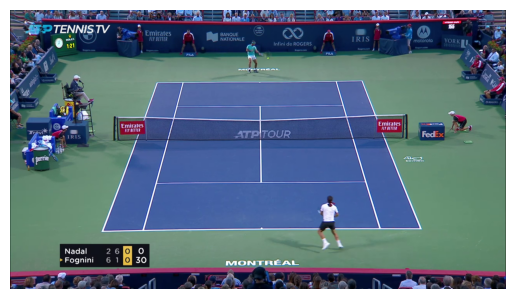

In [8]:
import matplotlib.pyplot as plt

img = cv2.imread(f'tennis_court_det_dataset/data/images/{id}.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  
plt.show()


In [9]:
img.shape

(720, 1280, 3)

In [10]:
w = img.shape[1]
h = img.shape[0]
print(h,w)

720 1280


In [11]:
img = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])(img)

In [12]:
img.shape

torch.Size([3, 224, 224])

In [13]:
kps = np.array(kps).flatten()
kps

array([ 378,  186,  905,  184,  242,  566, 1058,  564,  445,  185,  345,
        566,  839,  185,  956,  564,  428,  247,  858,  246,  377,  445,
        919,  443,  643,  247,  648,  444])

In [14]:
kps = kps.astype(np.float32)
kps

array([ 378.,  186.,  905.,  184.,  242.,  566., 1058.,  564.,  445.,
        185.,  345.,  566.,  839.,  185.,  956.,  564.,  428.,  247.,
        858.,  246.,  377.,  445.,  919.,  443.,  643.,  247.,  648.,
        444.], dtype=float32)

In [15]:
kps[::2] *= 224.0 / w # Adjust w 
kps[1::2] *= 224.0 / h # Adjust h 
kps

array([ 66.15    ,  57.86667 , 158.375   ,  57.244446,  42.35    ,
       176.0889  , 185.15    , 175.46667 ,  77.875   ,  57.555557,
        60.375   , 176.0889  , 146.825   ,  57.555557, 167.3     ,
       175.46667 ,  74.9     ,  76.844444, 150.15    ,  76.53333 ,
        65.975   , 138.44444 , 160.825   , 137.82222 , 112.525   ,
        76.844444, 113.4     , 138.13333 ], dtype=float32)

In [16]:
from keypoints_dataset import KeypointsDataset

train_dataset = KeypointsDataset("tennis_court_det_dataset/data/images", "tennis_court_det_dataset/data/data_train.json")
val_dataset = KeypointsDataset("tennis_court_det_dataset/data/images", "tennis_court_det_dataset/data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [17]:
model = models.resnet152(pretrained=True)
# model.fc =  torch.nn.Linear(model.fc.in_features, 14*2)

c:\Users\LENOVO\anaconda3\envs\TENIS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\TENIS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [19]:
model.fc =  torch.nn.Linear(model.fc.in_features, len(kps))
model.fc

Linear(in_features=2048, out_features=28, bias=True)

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
imgs, kps = train_loader.__iter__().__next__()

In [25]:
epochs=100
for epoch in range(epochs):
    for i, (imgs,kps) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, iter {i+1}, loss: {loss.item()}")

In [ ]:
torch.save(model.state_dict(), "../models/keypoints_court.pth")